# Project Statement: Forecasting Air Pollution in Quito Using Time Series Analysis and Machine Learning

#### Integrantes:
- Enrique Merizalde
- Juan Aristizabal
- Domenica Escobar
- Jossue Játiva

#### Fecha de inicio: 12/04/2025

## CARGAR Y CONSOLIDAR:

Cargar conjunto de datos de 10 estaciones con variables como PM2.5, CO2 y Velocidad del viento. Consolidar en un DataFrame unificado, gestionando los datos faltantes con imputacion y visualizando las lagunas con missingno. Estandarizar formatos y remuestrar para predicciones mensuales (Suma de precipitación, media, etc.) y horas mediante pandas

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pygrinder import mcar
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_acc

print("CUDA disponible:", torch.cuda.is_available())
print("GPUs detectadas:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nombre GPU:", torch.cuda.get_device_name(0))

c:\Users\user\GitRepositories\UDLA\inteligencia_artificial_2\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-23 11:15:41 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 

CUDA disponible: True
GPUs detectadas: 1
Nombre GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# ----------------------- CARGA Y PREPROCESAMIENTO -----------------------
# Ruta de la carpeta con los archivos CSV
folder_path = 'Data/'

# Obtener lista de archivos CSV
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Cargar estaciones.csv
estaciones_df = pd.read_csv(os.path.join(folder_path, 'estaciones.csv'))

# Crear DataFrame final vacío
column_names = [
    "STATION_NAME", "Date_time", "LAT", "LON",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2", "PM10", "PRE", "RS", "TMP", "VEL"
]
final_df = pd.DataFrame(columns=column_names)

In [3]:
# Iterar sobre los archivos y construir final_df
for file in csv_files:
    if file == 'estaciones.csv':
        continue

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    var = file.split('.')[0].upper()

    # Renombrar PM2.5 → PM2 para mantener consistencia
    if var == 'PM2.5':
        var = 'PM2'

    df_long = df.melt(id_vars=["Date_time"], var_name="STATION_NAME", value_name=var)
    df_long = df_long.merge(estaciones_df, left_on="STATION_NAME", right_on="STATION", how="left")
    df_long = df_long[["STATION_NAME", "LAT", "LON", "Date_time", var]]

    if final_df.empty:
        final_df = df_long
    else:
        final_df = pd.merge(final_df, df_long, on=["STATION_NAME", "LAT", "LON", "Date_time"], how="outer")

pd.set_option('display.max_columns', None)

  STATION_NAME        Date      Time       LAT        LON  CO     DIR    HUM  \
0    BELISARIO  2004-01-01  00:00:00 -0.184731 -78.495989 NaN  336.54  98.06   
1    BELISARIO  2004-01-01  01:00:00 -0.184731 -78.495989 NaN  259.17  98.47   
2    BELISARIO  2004-01-01  02:00:00 -0.184731 -78.495989 NaN  348.76  98.65   
3    BELISARIO  2004-01-01  03:00:00 -0.184731 -78.495989 NaN  300.94  99.03   
4    BELISARIO  2004-01-01  04:00:00 -0.184731 -78.495989 NaN  248.61  86.85   

   LLU  NO2  O3  PM2  PM10  PRE   RS    TMP   VEL  
0  NaN  NaN NaN  NaN   NaN  NaN  0.0   9.93  0.52  
1  NaN  NaN NaN  NaN   NaN  NaN  0.0   9.14  0.54  
2  NaN  NaN NaN  NaN   NaN  NaN  0.0   8.71  0.54  
3  NaN  NaN NaN  NaN   NaN  NaN  0.0   8.63  0.58  
4  NaN  NaN NaN  NaN   NaN  NaN  0.0  10.18  2.48  


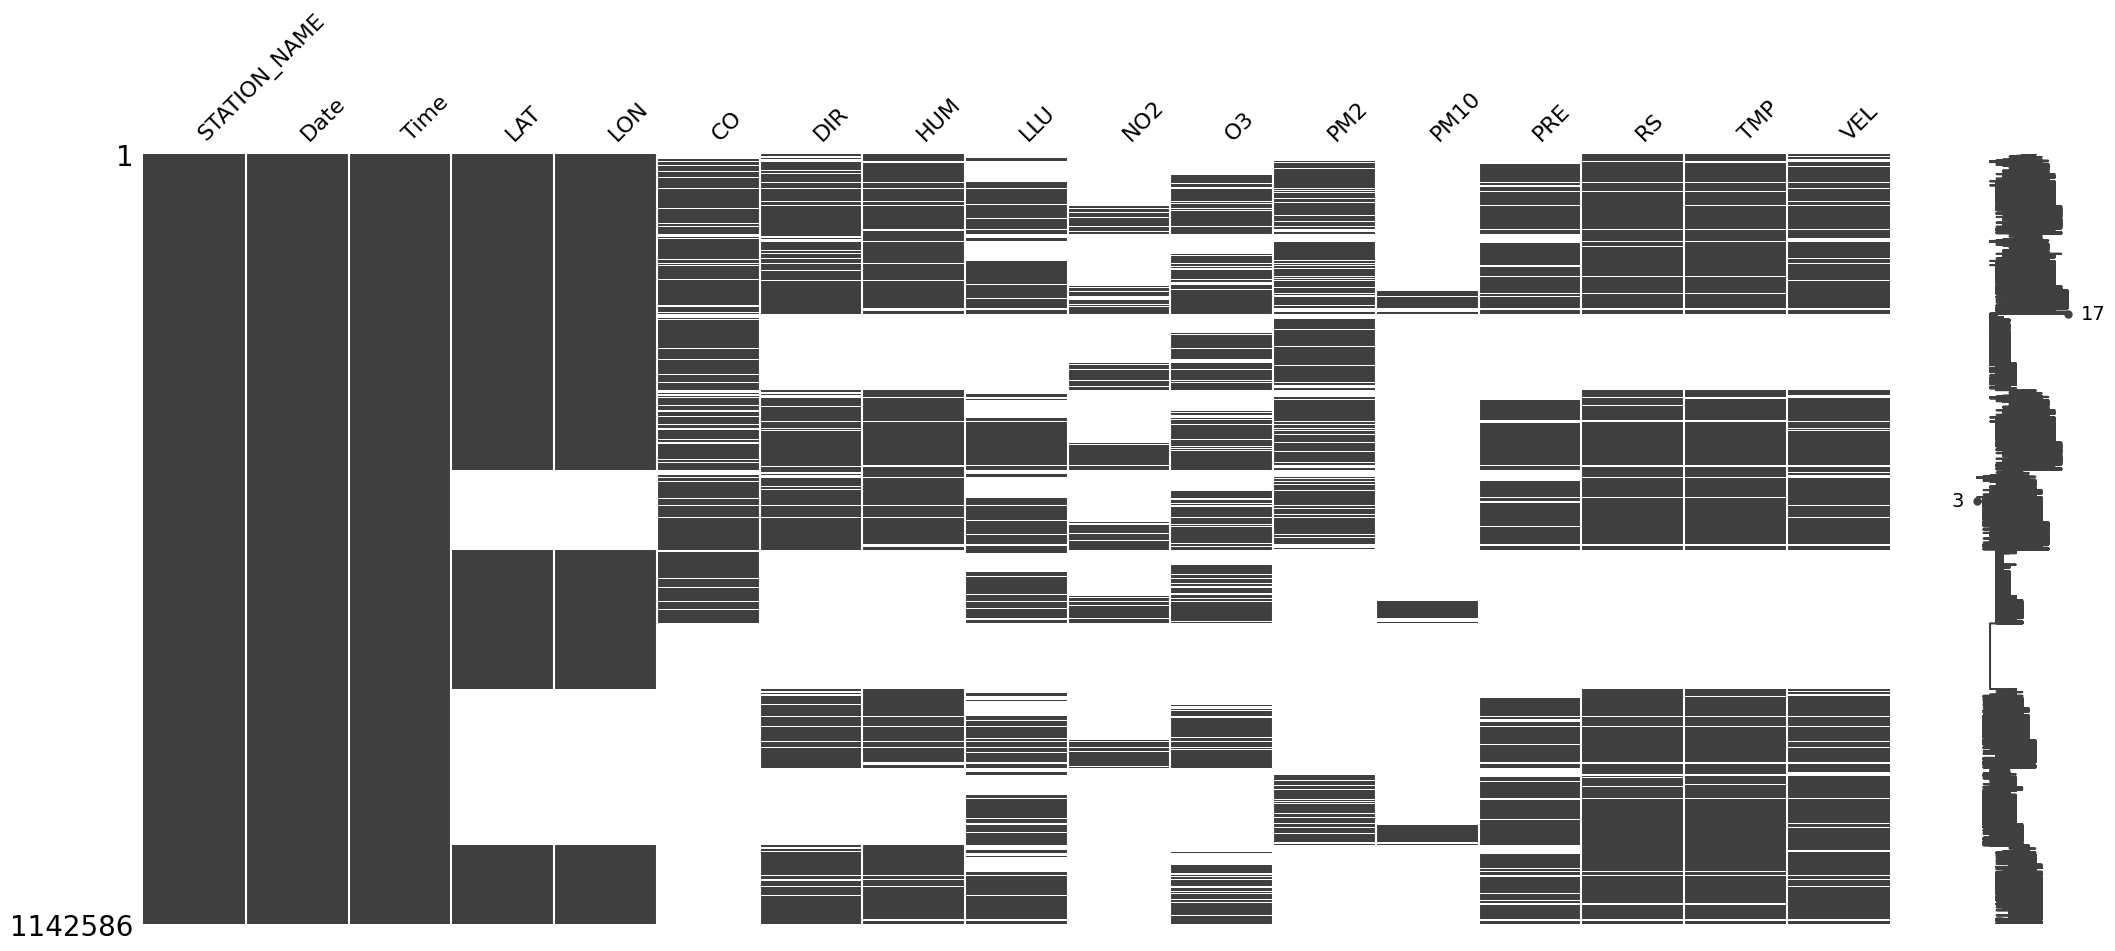

In [4]:
# ------------------------- LIMPIEZA DE DATA -----------------------
# Crear una nueva columna separando fecha y hora
final_df['Date_time'] = pd.to_datetime(final_df['Date_time'], errors='coerce', format='mixed')
final_df['Date'] = final_df['Date_time'].dt.date
final_df['Time'] = final_df['Date_time'].dt.time

# Eliminar columnas innecesarias
final_df.drop(columns=['Date_time'], inplace=True)

# Reordenar columnas
final_df = final_df[[
    "STATION_NAME", "Date", "Time", "LAT", "LON",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2", "PM10", "PRE", "RS", "TMP", "VEL"
]]

# Mostrar el gráfico de Missingno
msno.matrix(final_df)

# Mostrar el cuadro de la data
print(final_df.head())

In [5]:
# Poner fecha, hora y estación como índice
final_df.set_index(['Date', 'Time', 'STATION_NAME'], inplace=True)

# Parametros de imputacion
seq_len = 24

# Selecciona solo las columnas numéricas (excluye STATION_NAME, Date, Time)
n_features = len(final_df.columns)
data_array = final_df.to_numpy(dtype=np.float32)

n_samples = len(data_array) - seq_len + 1
data_windowed = np.array([
    data_array[i:i + seq_len] for i in range(n_samples)
])

# data_windowed.shape será (n_samples, seq_len, n_features)
print("Shape de data_windowed:", data_windowed.shape)

Shape de data_windowed: (1142563, 24, 14)


In [6]:
# Calcular el numero de veces que se repite cada fila
repeat_factor = data_array.shape[0] // data_windowed.shape[0]
extra_rows = data_array.shape[0] % data_windowed.shape[0]

# Repetir las filas para que coincidan con el tamaño original
expanded_array = np.repeat(data_windowed, repeat_factor, axis=0)

# Si hay filas extra, agregarlas al final
if extra_rows > 0:
    expanded_array = np.vstack((expanded_array, data_windowed[:extra_rows]))

expanded_array[-extra_rows:,0,:] = data_array[-extra_rows:]

expanded_array.shape

(1142586, 24, 14)

In [7]:
# Iniciar normalización
scaler = MinMaxScaler()

data_windowed = expanded_array.copy()

# Reajustar la forma para normalizar correctamente (Colapsar la dimensión de tiempo y de muestra)
data_windowed_reshaped = data_windowed.reshape(-1, data_windowed.shape[-1])

# Ajustar y transformar los datos
data_windowed_scaled = scaler.fit_transform(data_windowed_reshaped)

# restaurar la forma original
data_windowed_scaled = data_windowed_scaled.reshape(data_windowed.shape)

print("Shape de los datos normalizados:", data_windowed_scaled.shape)

Shape de los datos normalizados: (1142586, 24, 14)


In [9]:
# Inicializar el imputador SAITS
saits_imputer = SAITS(
    n_steps=seq_len, n_features=n_features,
    n_layers=1,
    d_model=32,
    d_ffn=64,
    n_heads=2,
    d_k=32, d_v=32,
    dropout=0.1,
    epochs=4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

dataset = {"X": data_windowed_scaled}

# Entrenar el modelo antes de predecir
saits_imputer.fit(dataset)

batch_size = 1000
imputed_batches = []
for i in range(0, data_windowed_scaled.shape[0], batch_size):
    batch = data_windowed_scaled[i:i+batch_size]
    pred = saits_imputer.predict({"X": batch})
    # Extrae el array imputado del dict
    imputed = pred["imputation"] if isinstance(pred, dict) and "imputation" in pred else None
    if isinstance(imputed, np.ndarray) and imputed.ndim == 3:
        imputed_batches.append(imputed)
    else:
        print(f"Warning: batch {i//batch_size} prediction is not a valid array. Got: {type(imputed)}, shape: {getattr(imputed, 'shape', None)}")

if len(imputed_batches) > 0:
    imputed_data = np.concatenate(imputed_batches, axis=0)
else:
    raise ValueError("No valid batches were predicted.")

2025-06-23 12:26:47 [INFO]: Using the given device: cuda
2025-06-23 12:26:47 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-06-23 12:26:47 [INFO]: Using customized MAE as the training loss function.
2025-06-23 12:26:47 [INFO]: Using customized MSE as the validation metric function.
2025-06-23 12:26:47 [WARNING]: ‼️ d_model must = n_heads * d_k, it should be divisible by n_heads and the result should be equal to d_k, but got d_model=32, n_heads=2, d_k=32
2025-06-23 12:26:47 [WARNING]: ⚠️ d_model is reset to 64 = n_heads (2) * d_k (32)


2025-06-23 12:26:47 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 56,208
2025-06-23 12:43:47 [INFO]: Epoch 001 - training loss (MAE): 0.0141
2025-06-23 12:59:27 [INFO]: Epoch 002 - training loss (MAE): 0.0089
2025-06-23 13:16:05 [INFO]: Epoch 003 - training loss (MAE): 0.0080
2025-06-23 13:36:46 [INFO]: Epoch 004 - training loss (MAE): 0.0074
2025-06-23 13:36:46 [INFO]: Finished training. The best model is from epoch#4.


<Axes: >

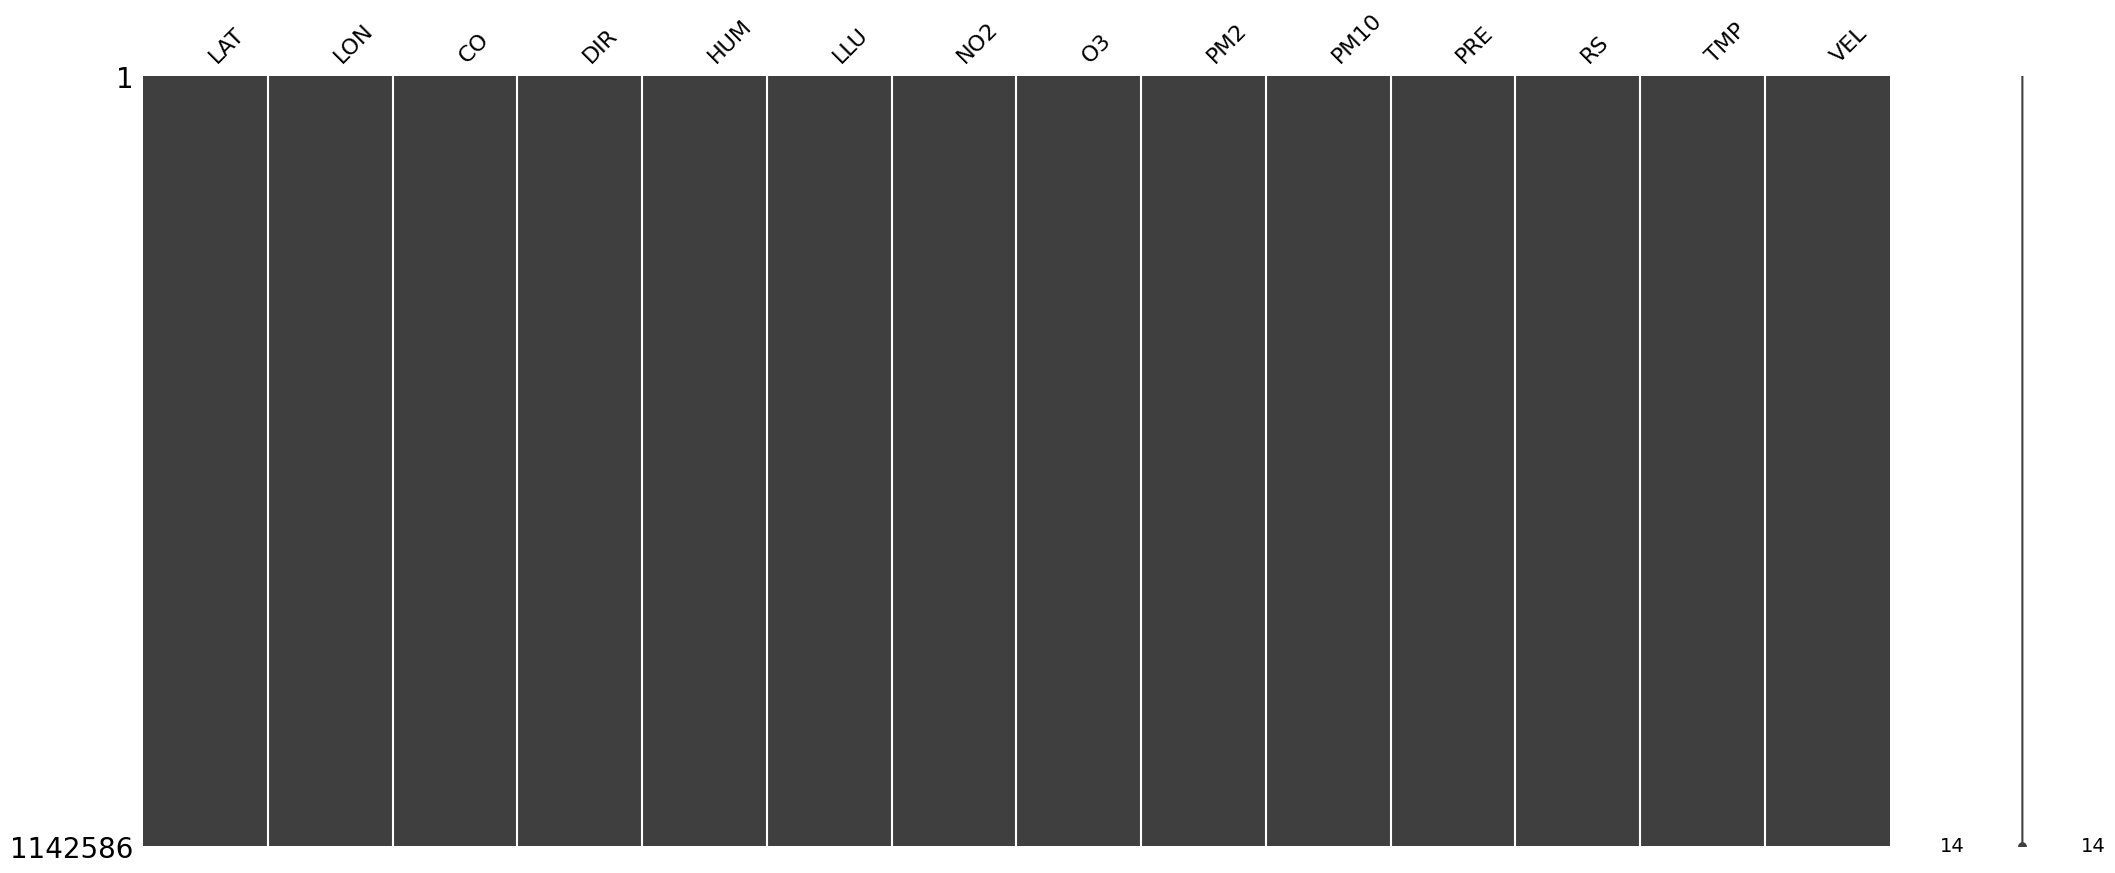

In [10]:
# Asegurar que reshape sea correcto para desnormalizar
imputed_data_reshaped = imputed_data.reshape(-1, imputed_data.shape[-1])

# desnormalizar los datos
imputed_data_descaled = scaler.inverse_transform(imputed_data_reshaped)

# Restaurar la forma original
imputed_data_descaled = imputed_data_descaled.reshape(imputed_data.shape)

# Extraer los datos imputados para el intervalo removido
imputed_data_final = imputed_data_descaled[:, 0, :]
imputed_data_final
msno.matrix(pd.DataFrame(imputed_data_final, columns=final_df.columns))

In [1]:
# poner test y train, donde test es el 10% de los datos
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(imputed_data_final, test_size=0.1, random_state=42)
Y_train, Y_test = train_test_split(data_array, test_size=0.1, random_state=42)

# escalar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

# Preparar los datos LSTM
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                              torch.tensor(Y_train_scaled, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                                torch.tensor(Y_test_scaled, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir el modelo LSTM
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Tomar la última salida de la secuencia
        return out
    
# Inicializar el modelo, la función de pérdida y el optimizador
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NameError: name 'imputed_data_final' is not defined

In [ ]:
# Entrenar el modelo
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Añadir dimensión de secuencia
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Evaluar el modelo
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1))  # Añadir dimensión de secuencia
        test_predictions.append(outputs.numpy())
        test_targets.append(targets.numpy())
    test_predictions = np.concatenate(test_predictions, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

# Calcular la precisión
accuracy = calc_acc(test_predictions, test_targets)
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# Verificar la precisión de las predicciones
plt.figure(figsize=(10, 6))
for i, col in enumerate(final_df.columns):
    plt.subplot(4, 4, i + 1)
    plt.plot(test_targets[:, i], label='Real', alpha=0.5)
    plt.plot(test_predictions[:, i], label='Predicción', alpha=0.5)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()